# Custom potential

We solve the 1D Gross-Pitaevskii equation with a custom potential.
This is similar to Gross-Pitaevskii equation in one dimension and we
show how to define local potentials attached to atoms, which allows for
instance to compute forces.

In [1]:
using DFTK
using LinearAlgebra

First, we define a new element which represents a nucleus generating a custom
potential

In [2]:
struct ElementCustomPotential <: DFTK.Element
    pot_real::Function      # Real potential
    pot_fourier::Function   # Fourier potential
end

We need to extend two methods to access the real and Fourier forms of
the potential during the computations performed by DFTK

In [3]:
function DFTK.local_potential_fourier(el::ElementCustomPotential, q::Real)
    return el.pot_fourier(q)
end
function DFTK.local_potential_real(el::ElementCustomPotential, r::Real)
    return el.pot_real(r)
end

We set up the lattice. For a 1D case we supply two zero lattice vectors

In [4]:
a = 10
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

In this example, we want to generate two Gaussian potentials generated by
two nuclei localized at positions ``x_1`` and ``x_2``, that are expressed in
``[0,1)`` in fractional coordinates. ``|x_1 - x_2|`` should be different from
``0.5`` to break symmetry and get nonzero forces.

In [5]:
x1 = 0.2
x2 = 0.8;

We define the width of the Gaussian potential generated by one nucleus

In [6]:
L = 0.5;

We set the potential in its real and Fourier forms

In [7]:
pot_real(x) = exp(-(x/L)^2)
pot_fourier(q::T) where {T <: Real} = exp(- (q*L)^2 / 4);

And finally we build the elements and set their positions in the `atoms`
array. Note that in this example `pot_real` is not required as all applications
of local potentials are done in the Fourier space.

In [8]:
nucleus = ElementCustomPotential(pot_real, pot_fourier)
atoms = [nucleus => [x1*[1,0,0], x2*[1,0,0]]];

Setup the Gross-Pitaevskii model

In [9]:
C = 1.0
α = 2;
n_electrons = 1  # Increase this for fun
terms = [Kinetic(),
         AtomicLocal(),
         PowerNonlinearity(C, α),
]
model = Model(lattice; atoms=atoms, n_electrons=n_electrons, terms=terms,
              spin_polarization=:spinless);  # use "spinless electrons"

We discretize using a moderate Ecut and run a SCF algorithm to compute forces
afterwards. As there is no ionic charge associated to `nucleus` we have to specify
a starting density and we choose to start from a zero density.

In [10]:
Ecut = 500
basis = PlaneWaveBasis(model, Ecut)
ρ = zeros(complex(eltype(basis)), basis.fft_size)
scfres = self_consistent_field(basis, tol=1e-8, ρ=from_fourier(basis, ρ))
scfres.energies

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   0.293932915778          NaN   4.29e-01    8.0 
  2   0.474643650560     1.81e-01   6.09e-01    2.0 
  3   0.263791732284    -2.11e-01   1.88e-01    2.0 
  4   0.242698929532    -2.11e-02   1.55e-02    2.0 
  5   0.242634450294    -6.45e-05   2.42e-03    2.0 
  6   0.242633413294    -1.04e-06   2.60e-04    2.0 
  7   0.242633379122    -3.42e-08   6.59e-05    2.0 
  8   0.242633376700    -2.42e-09   2.39e-05    1.0 


Energy breakdown:
    Kinetic             0.0304509 
    AtomicLocal         0.0972466 
    PowerNonlinearity   0.1149359 

    total               0.242633376700 


Computing the forces can then be done as usual:

In [11]:
hcat(forces(scfres)...)

2×1 Array{StaticArrays.SArray{Tuple{3},Float64,1,3},2}:
 [-0.03871875205180811, 0.0, 0.0]
 [0.03872738752833582, 0.0, 0.0] 

Extract the converged total local potential

In [12]:
tot_local_pot = DFTK.total_local_potential(scfres.ham)[:, 1, 1]; # use only dimension 1

Extract other quantities before plotting them

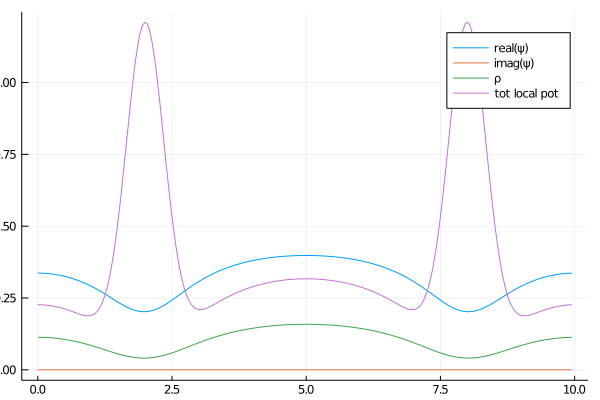

In [13]:
ρ = real(scfres.ρ.real)[:, 1, 1]  # converged density
ψ_fourier = scfres.ψ[1][:, 1];    # first kpoint, all G components, first eigenvector
ψ = G_to_r(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
ψ /= (ψ[div(end, 2)] / abs(ψ[div(end, 2)]));

using Plots
x = a * vec(first.(DFTK.r_vectors(basis)))
p = plot(x, real.(ψ), label="real(ψ)")
plot!(p, x, imag.(ψ), label="imag(ψ)")
plot!(p, x, ρ, label="ρ")
plot!(p, x, tot_local_pot, label="tot local pot")